<h5 style="color:rgba(0, 0, 178, 0.6);">This code hidden warrnings</h5>

In [1]:
import warnings
warnings.filterwarnings('ignore')

<h5 style="color:rgba(0, 0, 178, 0.6);">Install librarys that we need</h5>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from tensorflow import keras
from sklearn.cluster import KMeans
import random
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from Data_Prepear import data_prepear
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
tf.__version__

2024-10-26 20:08:15.762258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 20:08:15.765148: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 20:08:15.774269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 20:08:15.789095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 20:08:15.793466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 20:08:15.804601: I tensorflow/core/platform/cpu_feature_gu

'2.17.0'

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# df1 = df1[(df1["dp_tubing"] > 100) & (df1["bhp"] > 200) & (df1["bht"] > 80)]
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')

df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2014-04-21,235.873938,106.375468,166.933556,11.407277,195812.61,0
2014-04-22,235.996225,106.379720,166.985180,11.345026,172837.67,1
2014-04-23,235.831538,106.386644,166.890508,11.429508,181708.34,2
2014-04-24,235.704145,106.396780,166.803572,6.683832,119219.71,3
2014-04-25,235.913569,106.402976,166.910149,11.410404,184558.56,4


In [4]:
create_data = data_prepear(df, target_col ="QG", filter_value=90)
X_train, y_train, X_test, y_test = create_data.creator()

<h5 style="color:rgba(0, 0, 178, 0.6);">Create a function that build a dynamic model that can change the shape of the NN model with hyper parameters(hp) parameters</h5>

In [5]:
y_train.columns

Index(['y_step_1 QG', 'y_step_2 QG', 'y_step_3 QG', 'y_step_4 QG',
       'y_step_5 QG', 'y_step_6 QG', 'y_step_7 QG', 'y_step_8 QG',
       'y_step_9 QG', 'y_step_10 QG'],
      dtype='object')

In [7]:
model = LinearRegression() 
model.fit(X_train, y_train["y_step_4 QG"])

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)

In [8]:
ss = StandardScaler()
ss.fit(df.QG.values.reshape(df.QG.shape[0],1))
true_y_train = ss.inverse_transform(y_train["y_step_4 QG"].values.reshape(y_train["y_step_4 QG"].shape[0],1))
true_y_test = ss.inverse_transform(y_test["y_step_4 QG"].values.reshape(y_test["y_step_4 QG"].shape[0],1))
true_y_fit = ss.inverse_transform(y_fit)
true_y_pred = ss.inverse_transform(y_pred)

In [9]:
train_rmse = mean_squared_error(true_y_train, true_y_fit, squared=False)
test_rmse = mean_squared_error(true_y_test , true_y_pred, squared=False)
range_train =  np.max(true_y_train) - np.min(true_y_train)
range_test = np.max(true_y_test) - np.min(true_y_test)
print("train RMSE: ",train_rmse)
print("train Range:",range_train)
print("Percent_Erorr:", (train_rmse/range_train)*100, "%")
print("test_RMSE: ", test_rmse)
print("test Range:",range_test)
print("Percent_Erorr:", (test_rmse/range_test)*100, "%")

train RMSE:  28124.22368190512
train Range: 316505.2734002648
Percent_Erorr: 8.885862589195517 %
test_RMSE:  12001.055444782869
test Range: 93600.22000000003
Percent_Erorr: 12.821610296196809 %


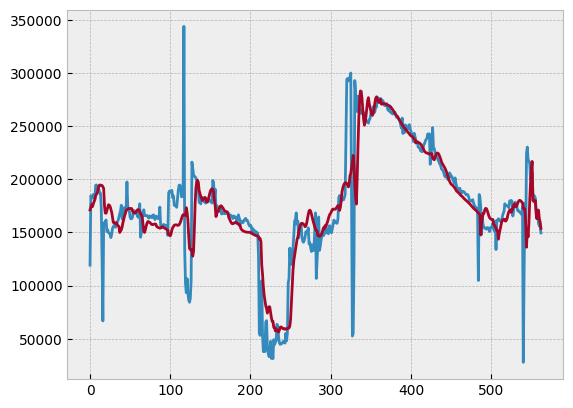

In [10]:
plt.plot(true_y_train)
plt.plot(true_y_fit)

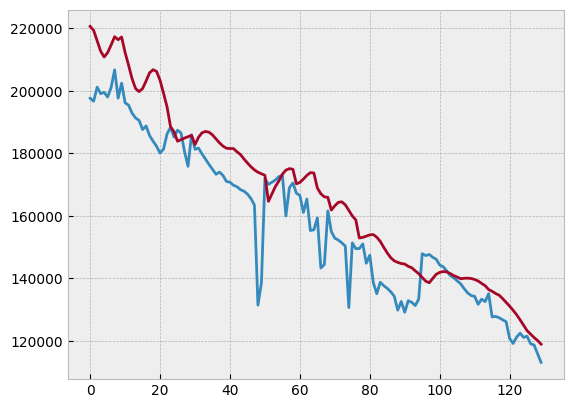

In [11]:
plt.plot(true_y_test)
plt.plot(true_y_pred)

[Text(0.5, 1.0, 'Train'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

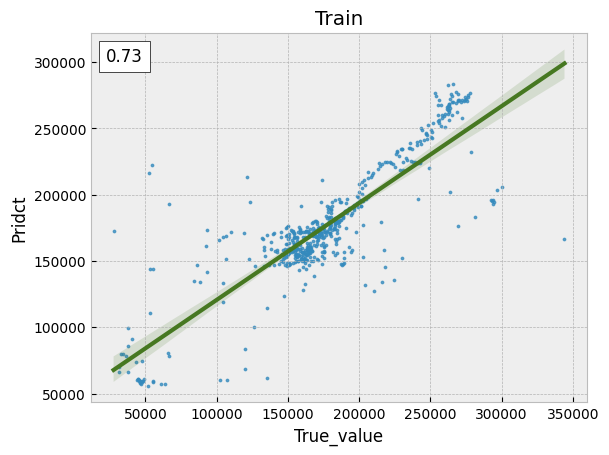

In [12]:
corr = r2_score(true_y_train, true_y_fit)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_train,
    y = true_y_fit,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="Train", xlabel="True_value", ylabel="Pridct")

[Text(0.5, 1.0, 'test'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

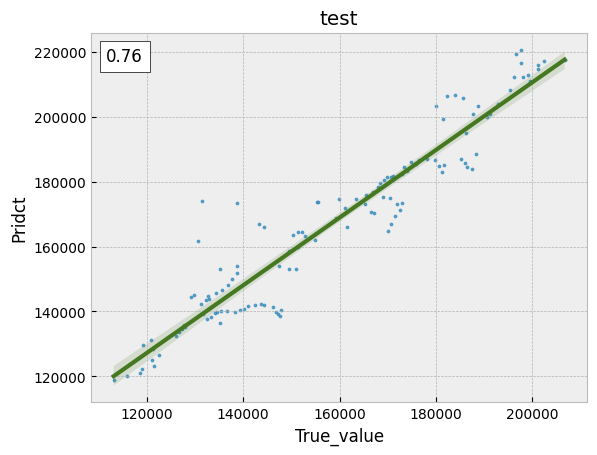

In [13]:
corr = r2_score(true_y_test, true_y_pred)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_test,
    y = true_y_pred,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="test", xlabel="True_value", ylabel="Pridct")